In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
from pydataset import data
coal = data('coal')
coal['count']=1
coal = coal.apply(np.floor).groupby('date').sum().reset_index()

A client comes to you with this problem:

> _The coal company I work for is trying to make mining safer. We made some change around 1900 that seemed to improve things, but the records are all archived. Tracking down such old records can be expensive, and it would help a lot if we could narrow the search. Can you tell us what year we should focus on?_

> _Also, it would really help to know this is a real effect, and not just due to random variability - we don't want to waste resources diggin up the records if there's not really anything there._

> _Here's the data:_

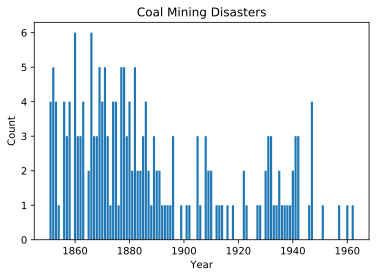

In [3]:
plt.bar(coal['date'], coal['count'])
plt.title("Coal Mining Disasters")
plt.xlabel('Year')
plt.ylabel('Count');

Assuming there's no foul play involved, it seems safe to assume incidents are independent. And since this is count data, our natural place to start is with a Poisson distribution. Let's cast this as *Poisson regression* - independent events, with the event rate changing over time.



In [4]:
mod = pm.Model()
with mod:
    d0 = pm.Uniform('changepoint', 1860, 1960)    
    μ = pm.HalfNormal('μ', sd=4, shape=2)
    grp = (coal['date'].values > d0) * 1
    y_obs = pm.Normal('y_obs', mu=μ[grp], observed = coal['count'].values)

With the model in hand, we can move ahead to fitting. Since we're doing Bayesian modeling, we won't just find a point estimate (as in MLE or MAP estimation). Rather, we'll sample from the posterior distribution - the distribution of the parameters, given the data.

There are lots of approaches to this, and PyMC3 makes it easy. Let's use *slice sampling* - for now don't worry too much about why this is a good way to go.

In [5]:
with mod:
    step =  pm.Slice()
    trace = pm.sample(step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [μ_log__]
>Slice: [changepoint_interval__]
100%|██████████| 1000/1000 [00:01<00:00, 763.11it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '24311' (I am process '24312')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/chad/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '24311' (I am process '24313')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/chad/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '24312' (I am process '24313')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/chad/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.3-64/lock_dir
The number of effecti

Here's  a plot of the results. On the left we have posterior density estimates for each variable; on the right are plots of the results.

PyMC3 samples in multiple *chains*, or independent processes. Here we used 4 chains. In a good fit, the density estimates across chains should be similar. Ideally, time-dependent plots look like random noise, with very little autocorrelation.

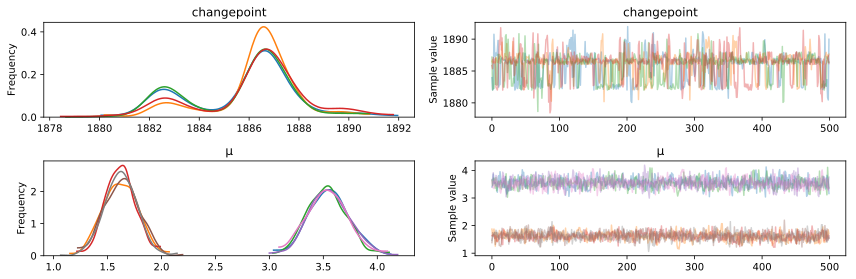

In [6]:
pm.traceplot(trace);

Remember, $\mu$ is a vector. We have two mean values, one on each side of the changepoint.

We see some interesting bimodality in the changepoint estimate; let's get back to that. Also, the poterior distributions two means are very well-separated. It's almost certain there was a real change in the rate of disasters - it's not just faulty perception on our part.

One thing we might be concerned with is the potential for strong correlations in our posterior estimates. If the changepoint occurred very early, the second group would include some of the higher counts, potentially inflating its mean. This wouldn't necessarily be cause for alarm, but it's something we should be sure to understand.

Let's visualize the dependency, to see if this is the case.

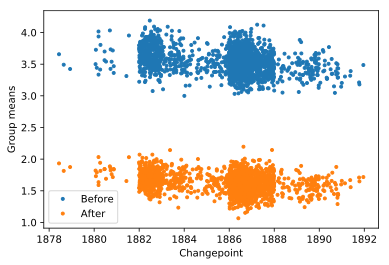

In [7]:
plt.plot(trace['changepoint'], trace['μ'], '.', alpha=0.3)
plt.xlabel('Changepoint')
plt.legend(["Before", "After"])
plt.ylabel('Group means');

We do see some slight dependency. For very early changepoints, the `After` group is inflated, and for very late changepoints, the `Before` group is supressed. But the effect appears to be minimal.

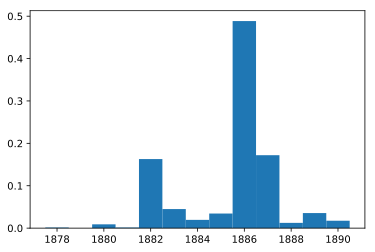

In [8]:
plt.hist(np.floor(trace['changepoint']), bins=13, normed=True,align='left');

In [9]:
df = pd.DataFrame({'changepoint': trace['changepoint'], 'μ0': trace['μ'][:,0], 'μ1': trace['μ'][:,1]})

In [10]:
%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300


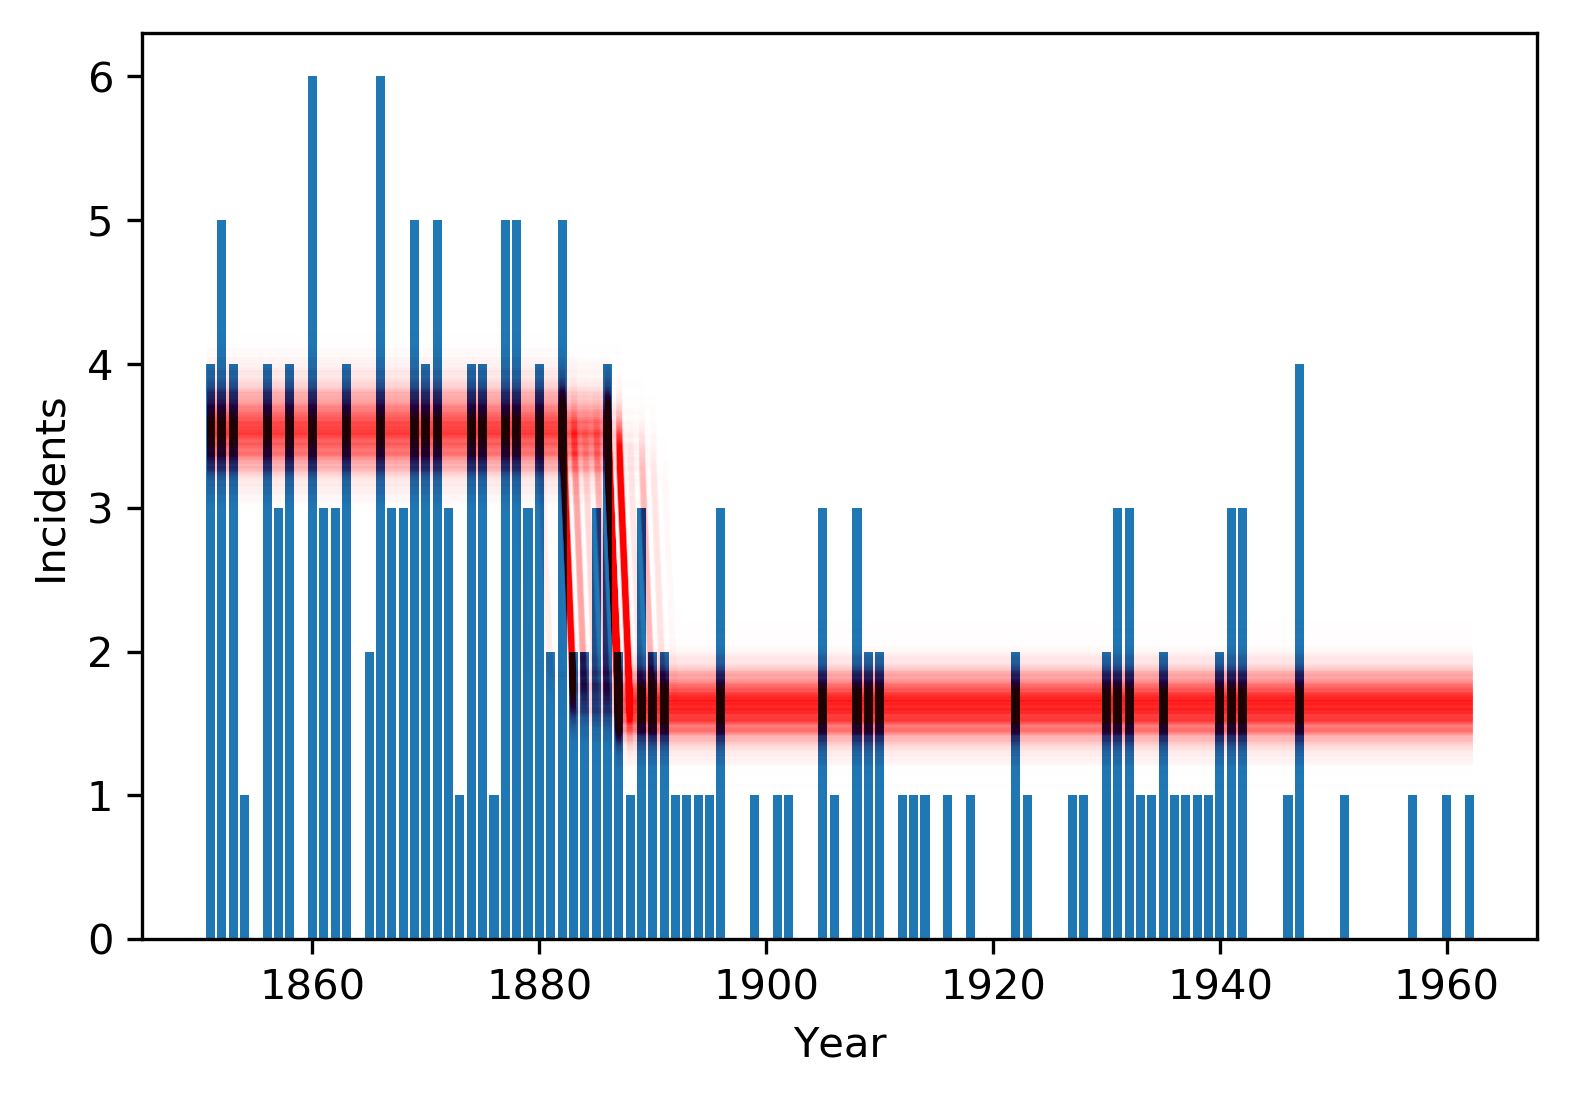

In [11]:
plt.bar(coal['date'], coal['count'], label='count')
plt.xlabel('Year')
plt.ylabel('Incidents')

def pl(pt):
    grp = (coal['date'] > pt['changepoint']) * 1
    line = plt.plot(coal['date'],pt['μ0']* (1 - grp) + pt['μ1'] * grp, color='red', alpha=0.005)    

    
df.apply(pl,axis=1);


Let's zoom in near the change point:

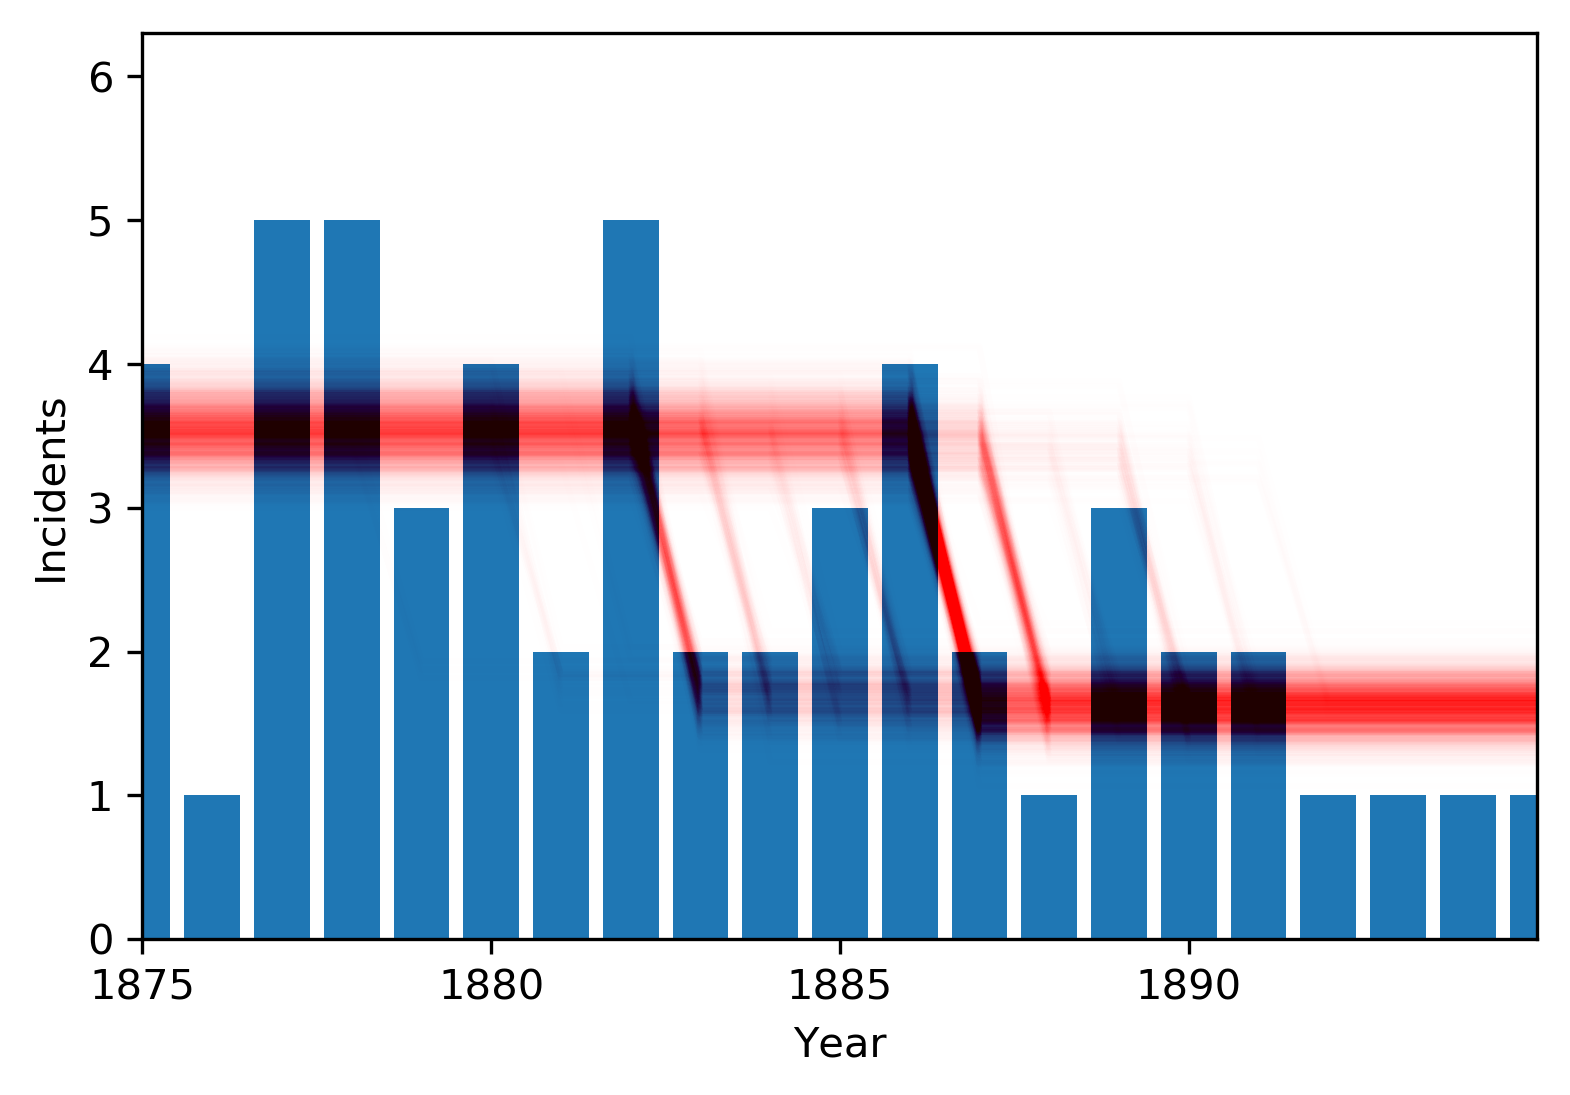

In [12]:
plt.bar(coal['date'], coal['count'])

plt.xlabel('Year')
plt.ylabel('Incidents')

def pl(pt):
    grp = (coal['date'] > pt['changepoint']) * 1
    plt.plot(coal['date'],pt['μ0']* (1 - grp) + pt['μ1'] * grp, color='red', alpha=0.005)

    
df.apply(lambda pt: pl(pt),axis=1);
plt.xlim([1875,1895])
plt.xticks(range(1875,1895,5));

This last plot helps explain the bimodality we were seeing before. Counts in 1885-86 are higher than surrounding years. Maybe the changepoint is just before them, and the higher counts are due to randomness. Or maybe the changepoint is immediately after, and the high counts are because the change has not yet occurred. Either scenario is plausible, though the latter is much more likely.

Much less plausible (according to the model) is the hypothesis that 1885-86 are right at the changepoint. The low counts in 1883-84 would be especially 